<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/0629_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow_model_optimization
!pip install memory_profiler

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd
import random
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import time
import psutil
import gc

In [ ]:
# 시드 설정
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 환경 변수 설정 (결정론적 연산 보장)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [ ]:
# 원본 모델 정의
def create_model():
    model = keras.Sequential(name='CNN_Model')
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                                  input_shape=(X_train.shape[1], X_train.shape[2]), name='conv1'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, name='maxpool1'))
    model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='conv2'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, name='maxpool2'))
    model.add(keras.layers.Flatten(name='flatten'))
    model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001), name='dense1'))
    model.add(keras.layers.Dropout(0.3, name='dropout'))
    model.add(keras.layers.Dense(len(categories), activation='softmax', name='output'))
    return model

In [ ]:
# 가지치기 함수
def prune_weights(model, pruning_percentage=0.8):
    pruned_model_layers = []
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dense) or isinstance(layer, keras.layers.Conv1D):
            weights, biases = layer.get_weights()
            abs_weights = np.abs(weights)
            threshold = np.percentile(abs_weights, pruning_percentage * 100)
            new_weights = np.where(abs_weights < threshold, 0, weights)
            pruned_model_layers.append((new_weights, biases))
        else:
            pruned_model_layers.append(layer)
    return pruned_model_layers

# 가지치기된 모델의 새로운 구조 생성 함수
def create_pruned_model(pruned_model_layers):
    model = keras.Sequential(name='Pruned_CNN_Model')
    input_shape_set = False  # 입력 형태 설정 여부 확인 플래그
    for layer_weights in pruned_model_layers:
        if isinstance(layer_weights, tuple):  # Conv1D 또는 Dense 레이어
            weights, biases = layer_weights
            if len(weights.shape) == 3:  # Conv1D 레이어
                if not input_shape_set:
                    new_layer = keras.layers.Conv1D(filters=weights.shape[2], kernel_size=weights.shape[0], activation='relu',
                                                    input_shape=(X_train.shape[1], X_train.shape[2]))
                    input_shape_set = True
                else:
                    new_layer = keras.layers.Conv1D(filters=weights.shape[2], kernel_size=weights.shape[0], activation='relu')
            elif len(weights.shape) == 2:  # Dense 레이어
                new_layer = keras.layers.Dense(units=weights.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))
            model.add(new_layer)
            new_layer.set_weights([weights, biases])
        else:  # MaxPooling1D, Flatten, Dropout, Dense(len(categories), activation='softmax')
            layer = layer_weights  # MaxPooling, Flatten, Dropout 레이어 객체
            if isinstance(layer, keras.layers.MaxPooling1D):
                model.add(keras.layers.MaxPooling1D(pool_size=2))
            elif isinstance(layer, keras.layers.Flatten):
                model.add(keras.layers.Flatten())
            elif isinstance(layer, keras.layers.Dropout):
                model.add(keras.layers.Dropout(0.3))
            elif isinstance(layer, keras.layers.Dense) and layer.activation == keras.activations.softmax:
                model.add(keras.layers.Dense(len(categories), activation='softmax'))
    return model

In [ ]:
# 원본 모델 학습
model = create_model()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/5
219/219 [==============================] - 78s 348ms/step - loss: 1.6714 - accuracy: 0.4789 - val_loss: 1.2401 - val_accuracy: 0.5869
Epoch 2/5
219/219 [==============================] - 76s 345ms/step - loss: 1.3124 - accuracy: 0.4997 - val_loss: 1.2900 - val_accuracy: 0.5869
Epoch 3/5
219/219 [==============================] - 76s 346ms/step - loss: 1.2967 - accuracy: 0.4997 - val_loss: 1.2157 - val_accuracy: 0.5869
Epoch 4/5
219/219 [==============================] - 76s 348ms/step - loss: 1.2667 - accuracy: 0.4997 - val_loss: 1.1824 - val_accuracy: 0.5869
Epoch 5/5
219/219 [==============================] - 77s 351ms/step - loss: 1.2553 - accuracy: 0.4997 - val_loss: 1.1665 - val_accuracy: 0.5869


In [ ]:
# 가지치기된 모델의 가중치와 바이어스 추출
pruned_model_layers = prune_weights(model, pruning_percentage=0.8)

In [ ]:
# 가지치기된 모델의 새로운 구조로 생성
pruned_model = create_pruned_model(pruned_model_layers)

In [ ]:
# 가지치기된 모델 재훈련
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_history = pruned_model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

In [ ]:
# 가지치기된 모델의 가중치 저장 (희소성 적용)
def save_sparse_model(model, file_path):
    with h5py.File(file_path, 'w') as f:
        for layer in model.layers:
            if isinstance(layer, keras.layers.Dense) or isinstance(layer, keras.layers.Conv1D):
                weights, biases = layer.get_weights()
                non_zero_indices = np.nonzero(weights)
                non_zero_weights = weights[non_zero_indices]
                f.create_dataset(layer.name + '_weights', data=non_zero_weights)
                f.create_dataset(layer.name + '_biases', data=biases)
                f.create_dataset(layer.name + '_non_zero_indices', data=np.array(non_zero_indices))
            else:
                weights = layer.get_weights()
                for i, weight in enumerate(weights):
                    f.create_dataset(layer.name + f'_weights_{i}', data=weight)

# 희소성 적용한 모델 저장
save_sparse_model(pruned_model, 'model_after_pruning_sparse.h5')

# 희소성 적용 모델 로드 함수
def load_sparse_model(file_path, original_model):
    with h5py.File(file_path, 'r') as f:
        for layer in original_model.layers:
            if isinstance(layer, keras.layers.Dense) or isinstance(layer, keras.layers.Conv1D):
                try:
                    non_zero_weights = f[layer.name + '_weights'][:]
                    biases = f[layer.name + '_biases'][:]
                    non_zero_indices = tuple(f[layer.name + '_non_zero_indices'][:])
                    original_weights = np.zeros(layer.get_weights()[0].shape)
                    original_weights[non_zero_indices] = non_zero_weights
                    layer.set_weights([original_weights, biases])
                except KeyError as e:
                    print(f"Could not load layer {layer.name}: {e}")
            else:
                weights = []
                i = 0
                while f'{layer.name}_weights_{i}' in f:
                    weights.append(f[layer.name + f'_weights_{i}'][:])
                    i += 1
                layer.set_weights(weights)

# 희소성 적용 모델 로드
model_for_evaluation = create_model()
load_sparse_model('model_after_pruning_sparse.h5', model_for_evaluation)

# 모델 컴파일
model_for_evaluation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Could not load layer conv1: "Unable to synchronously open object (object 'conv1_weights' doesn't exist)"
Could not load layer conv2: "Unable to synchronously open object (object 'conv2_weights' doesn't exist)"
Could not load layer dense1: "Unable to synchronously open object (object 'dense1_weights' doesn't exist)"
Could not load layer output: "Unable to synchronously open object (object 'output_weights' doesn't exist)"


In [ ]:
# 모델 크기 비교
original_model_size = os.path.getsize('model.h5') / (1024 * 1024)
sparse_model_size = os.path.getsize('model_after_pruning_sparse.h5') / (1024 * 1024)
print(f"Original Model Size: {original_model_size:.2f} MB")
print(f"Sparse Pruned Model Size: {sparse_model_size:.2f} MB")

Original Model Size: 439.50 MB
Sparse Pruned Model Size: 350.46 MB


In [ ]:
# 검증 데이터 평가
val_loss_after, val_accuracy_after = model_for_evaluation.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss_after:.4f}")
print(f"Validation Accuracy: {val_accuracy_after:.4f}")

40/40 [==============================] - 4s 70ms/step - loss: 1.3633 - accuracy: 0.5869
Validation Loss: 1.3633
Validation Accuracy: 0.5869


In [ ]:
# 테스트 데이터 평가
test_loss_after, test_accuracy_after = model_for_evaluation.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss_after:.4f}")
print(f"Test Accuracy: {test_accuracy_after:.4f}")

40/40 [==============================] - 3s 70ms/step - loss: 1.3633 - accuracy: 0.5869
Test Loss: 1.3633
Test Accuracy: 0.5869


In [ ]:
# 혼동 행렬 및 성능 지표 출력 (테스트 데이터)
y_pred_after = model_for_evaluation.predict(X_test)
y_pred_after = np.argmax(y_pred_after, axis=1)
conf_matrix_test_after = confusion_matrix(y_test_encoded, y_pred_after)
class_report_test_after = classification_report(y_test_encoded, y_pred_after, target_names=categories)
f1_score_after = f1_score(y_test_encoded, y_pred_after, average='weighted')

40/40 [==============================] - 3s 65ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 성능 비교 출력
performance_comparison = {
    'Metric': ['Model Size (MB)', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy', 'F1 Score'],
    'Values': [sparse_model_size, val_loss_after, val_accuracy_after, test_loss_after, test_accuracy_after, f1_score_after]
}

performance_df = pd.DataFrame(performance_comparison)
print("\nPerformance Comparison:")
print(performance_df)


Performance Comparison:
                Metric      Values
0      Model Size (MB)  350.462837
1      Validation Loss    1.363306
2  Validation Accuracy    0.586854
3            Test Loss    1.363297
4        Test Accuracy    0.586854
5             F1 Score    0.434064


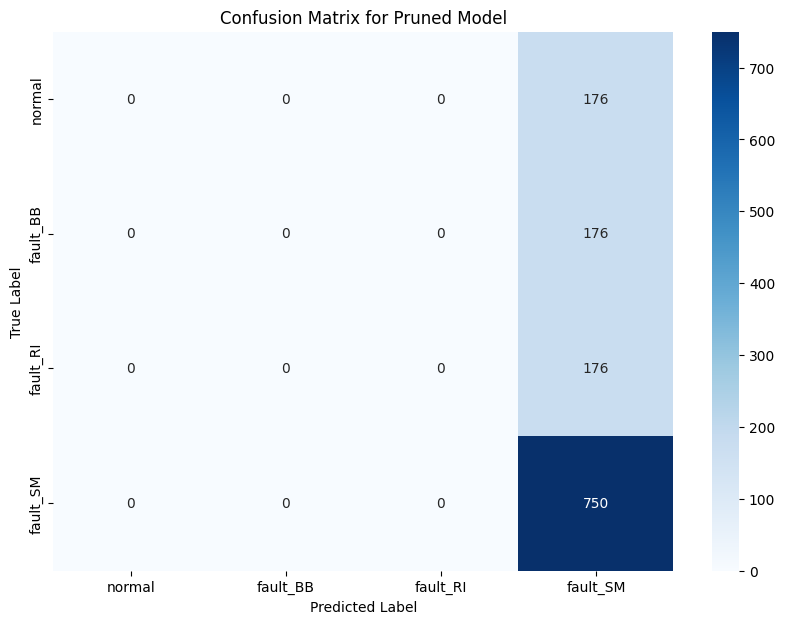

In [ ]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test_after, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pruned Model')
plt.show()

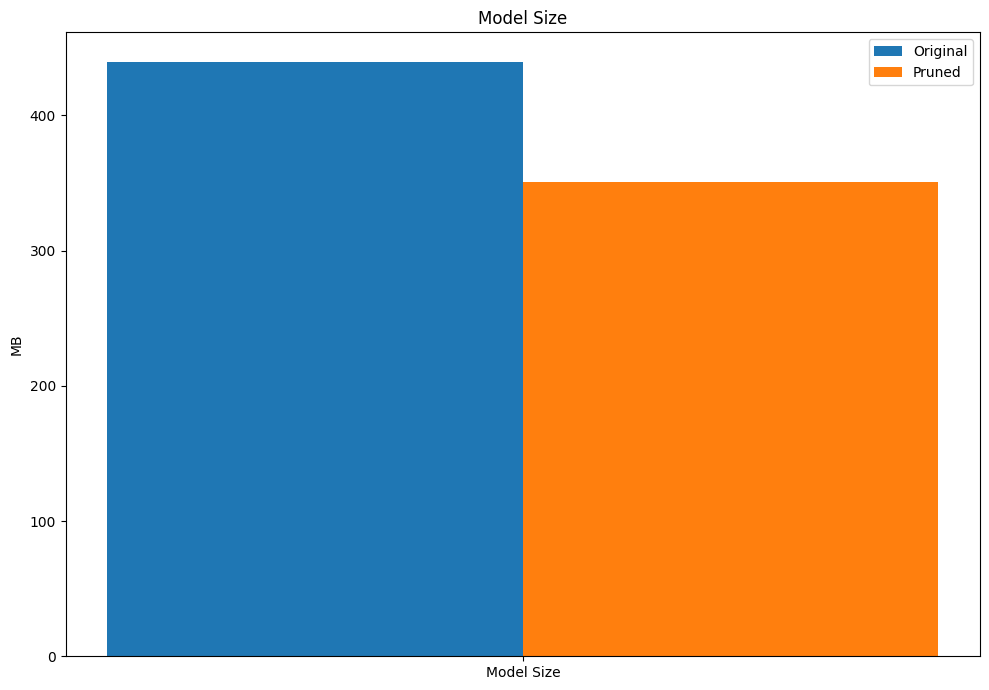

In [ ]:
# 모델 사이즈 비교 막대 그래프
labels = ['Model Size']
original_values = [original_model_size]
pruned_values = [sparse_model_size]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('MB')
ax.set_title('Model Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

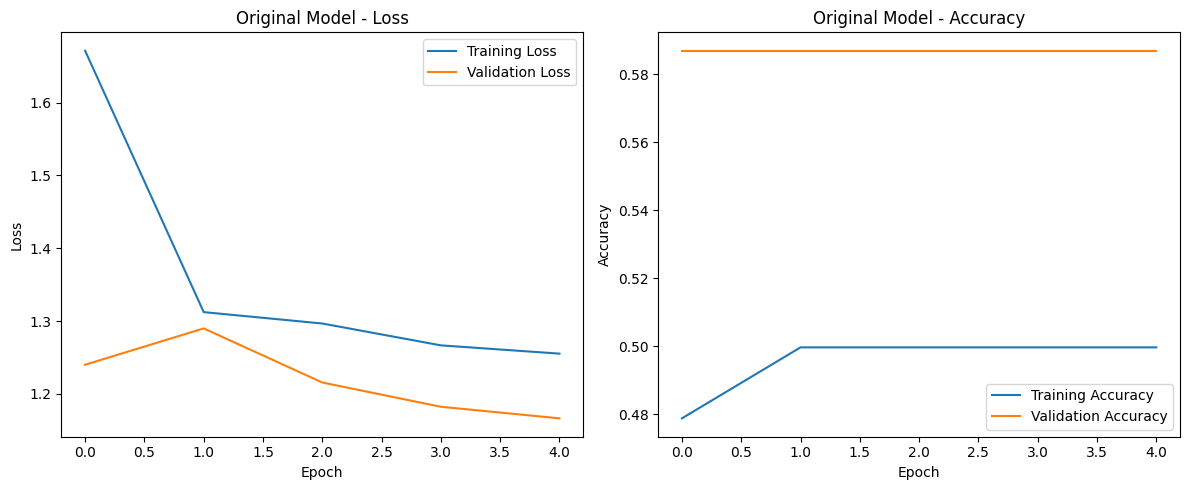

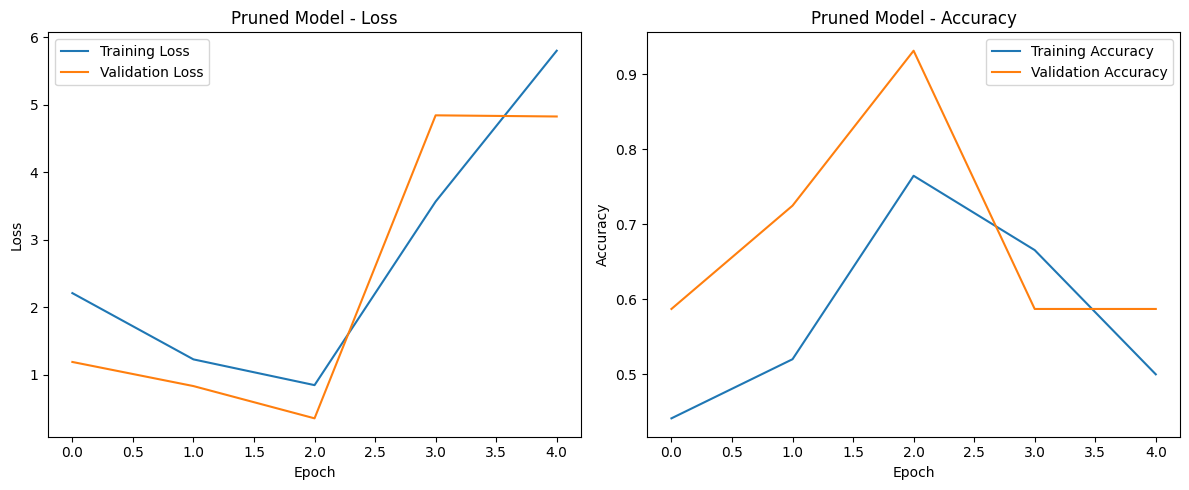

In [ ]:
# 모델 학습 과정 시각화
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, 'Original Model')
plot_training_history(pruned_history, 'Pruned Model')

In [ ]:
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

# 파라미터 수와 FLOPs 계산
def count_params_and_flops(model):
    # 파라미터 수 계산
    total_params = model.count_params()

    # 모델을 텐서플로 함수로 변환
    tf_model = tf.function(lambda x: model(x))
    concrete_func = tf_model.get_concrete_function(tf.TensorSpec([1] + list(model.input_shape)[1:], model.inputs[0].dtype))

    # 텐서플로 함수에서 그래프 추출
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()  # Extract the graph definition

    # FLOPs 계산
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')  # Pass the graph definition

        # Use ProfileOptionBuilder correctly to create options
        options = tf.profiler.experimental.ProfilerOptions(
            host_tracer_level = 3,
            python_tracer_level = 1,
            device_tracer_level = 1,
        )

        tf.profiler.experimental.start('logdir', options)
        # Run some operations to profile
        _ = model(tf.ones((1,) + model.input_shape[1:]))
        flops = tf.profiler.experimental.stop()

        flops = flops.total_float_ops if flops else 0  # Handle potential None return

    return total_params, flops

# 원본 모델의 파라미터 수와 FLOPs 측정
original_params, original_flops = count_params_and_flops(model)

# 가지치기 후 모델의 파라미터 수와 FLOPs 측정
pruned_params, pruned_flops = count_params_and_flops(model_for_evaluation)

print(f"Original Model Params: {original_params}")
print(f"Original Model FLOPs: {original_flops}")

print(f"Pruned Model Params: {pruned_params}")
print(f"Pruned Model FLOPs: {pruned_flops}")

RuntimeError: Exception encountered when calling layer 'conv1' (type Conv1D).

resource: Attempting to capture an EagerTensor without building a function.

Call arguments received by layer 'conv1' (type Conv1D):
  • inputs=tf.Tensor(shape=(1, 12001, 2), dtype=float32)

In [ ]:
# 파라미터 수와 FLOPs 비교 막대 그래프
labels = ['Parameters', 'FLOPs']
original_values = [original_params, original_flops]
pruned_values = [pruned_params, pruned_flops]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('Count')
ax.set_title('Comparison of Parameters and FLOPs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
# 추론 시간 및 메모리 사용량 측정
def measure_inference_time_and_memory(model, data):
    start_time = time.time()
    process = psutil.Process(os.getpid())
    start_memory = process.memory_info().rss
    predictions = model.predict(data)
    end_memory = process.memory_info().rss
    end_time = time.time()

    inference_time = end_time - start_time
    memory_usage = (end_memory - start_memory) / (1024 * 1024)  # MB 단위로 변환
    return inference_time, memory_usage

# 추론 시간 및 메모리 사용량 측정 (원본 모델)
original_inference_time, original_memory_usage = measure_inference_time_and_memory(model, X_test)

# 추론 시간 및 메모리 사용량 측정 (가지치기된 모델)
pruned_inference_time, pruned_memory_usage = measure_inference_time_and_memory(model_for_evaluation, X_test)

print(f"Original Model Inference Time: {original_inference_time:.4f} seconds")
print(f"Original Model Memory Usage: {original_memory_usage:.4f} MB")

print(f"Pruned Model Inference Time: {pruned_inference_time:.4f} seconds")
print(f"Pruned Model Memory Usage: {pruned_memory_usage:.4f} MB")

In [ ]:
# 추론 시간 및 메모리 사용량 비교 막대 그래프
labels = ['Inference Time (seconds)', 'Memory Usage (MB)']
original_values = [original_inference_time, original_memory_usage]
pruned_values = [pruned_inference_time, pruned_memory_usage]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('Count')
ax.set_title('Comparison of Inference Time and Memory Usage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()